# Popular Data Science Questions

In this project we are working for a company that creates data science content, be it books, online articles, videos or interactive text-based platforms like Dataquest.

We are tasked with figuring out what is best content to write about. Because we took this course, we know that given the lack of instructions there's some leeway in what "best" means here. Since we're passionate about helping people learn, we decide to scower the internet in search for the answer to the question "What is it that people want to learn about in data science?" (as opposed to determining the most profitable content, for instance).

Looking back to our first experience of learning programming we realize that [StackOverflow](https://stackoverflow.com/) is the most popular place where programmers share and ask data science/programming related questions. We also know that Stackoverflow is part of the network of websites called [StackExchange](https://en.wikipedia.org/wiki/Stack_Exchange).

**Disclaimer:** This project is part of the guided project for a Data Scientist Path on [dataquest.io](https://dataquest.io/). Content is provided by dataquest while code solutions are my own effort.

## Introduction

StackExchange hosts multiple websites in various fields such as mathematics, physics, philosophy, and [data science](https://datascience.stackexchange.com/)!

[Here](https://stackexchange.com/sites?view=list#percentanswered) are the all the sites under the umbrella of StackExchange.

Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

If you're not familiar with Stack Overflow or any other Stack Exchange site, you can check out this [tour](https://stackexchange.com/tour).

Being a multidisciplinary field, there a few Stack Exchange websites there are relevant to our goal here:
* [Data Science](https://datascience.stackexchange.com/)
* [Cross Validated](https://stats.stackexchange.com/) — a statistics site
* [Artificial Intelligence](https://ai.stackexchange.com/)
* [Mathematics](https://math.stackexchange.com/)
* [Stack Overflow](https://stackoverflow.com/)

And if we want to include Data Engineering, we can also consider:

* [Database Administrators](https://dba.stackexchange.com/)
* [Unix & Linux](https://unix.stackexchange.com/)
* [Software Engineering](https://softwareengineering.stackexchange.com/)

Out of all the websites, Data Science Stack Exchange (DSSE) website is the ideal candidate for the purposes of this analysis.

## Getting familiar with DSSE

Let's answer some questions and get familiar with DSSE

> What kind of questions are welcome on this site?
> > Questions regarding statistical learning, maching learning, specifics of certain algorithms and their implementations and pretty much everything data science related

> What, other than questions, does the site's home subdivide into?
> > Homepage also contains info on users, tags and unanswered questions. Listing Tags could be useful for our analysis

> What information is available in each post?
> > Each post contains the main question, the user who posted and tags associated and responses to the answers along with comments. The post also contains the votes on a questions as well as on the answers. The post also contains how many times the question was viewed and when it was posted. We ca 

If we roam around the website we can see that tags section contains each individual tag as well as number of questions with that tag. We can use this information to categorize the content.

To get started, we could use web scraping but there is an easier alternative. Stack Exchange provides a public data base for each of its websites. [Here's](https://data.stackexchange.com/datascience/query/new) a link to query and explore Data Science Stack Exchange's database. 
You can read more about Stack Exchange Data Explorer (SEDE) on its [help section](https://data.stackexchange.com/help) and on [this](https://data.stackexchange.com/tutorial) tutorial link.

## Exploring the Data Model

We can use the query tool to get the information we need. Note that SEDE uses a different dialect ([Transact-SQL](https://en.wikipedia.org/wiki/Transact-SQL) — Microsoft's SQL) than SQLite.

We can try to run this query and check the top 10 tags by count.

```sql
SELECT TOP 10 *
  FROM tags
 ORDER BY Count DESC;
```

Let's explore the DSSE's data model.

The `Posts` table seems quite interesting but there are quite a lot of columns. 
For our purpose we only need
* `Id` - Unique identifier for a post.
* `PostTypeId` - Unique identifier for type of post.
* `CreationDate` - The date and time of creation of the post.
* `Score` - Post's score
* `ViewCount` - Number of times the post was viewed.
* `Tags` - list of tags associated with the post.
* `AnswerCount` - number of answers on a post (only for question posts)
* `FavoriteCount` - How many times the question was [favored](https://meta.stackexchange.com/questions/53585/how-do-favorite-questions-work) (only applicable to question posts).

The last two columns provide information on the popularity of posts. This is something we can use.

Before that let's also check the types of posts available and which ones would be relevant for us.

```sql
SELECT p.PostTypeId, t.Name, COUNT(*) as NrOfPosts
  FROM posts as p
  INNER JOIN PostTypes as t on
    t.Id = p.PostTypeId
 GROUP BY p.PostTypeId, t.Name
 ORDER BY NrOfPosts DESC;
```

Due to volume we will ignore anything that is not a question or answer. Assuming on average each question has an answer we can simply focus on questions.
We will also limit the scope to looking at questions in 2019. Let's extract all columns indicated above for questions asked in 2019.

```sql
SELECT
    p.Id,
    p.PostTypeId,
    p.CreationDate,
    p.Score,
    p.ViewCount,
    p.Tags,
    p.AnswerCount,
    p.FavoriteCount
FROM
    Posts as p
INNER JOIN PostTypes as t on
    t.Id = p.PostTypeId
WHERE 1=1
    AND t.Id = 1
    AND YEAR(p.CreationDate) = 2019
```

We will extract the results into a csv file called `2019_questions.csv`

## Data Exploration

Let's load the dataset and explore it.

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the dataset
df = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

# view the first few rows
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [235]:
# check missing values in each column
df.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

There are many missing values in `FavoriteCount` column. Since `FavoriteCount` contains the number of times the question has been favored, we can safely assume missing values being 0.

In [236]:
# fill missing values of FavoriteCount colum and convert to correct datatype
df["FavoriteCount"] = df["FavoriteCount"].fillna(0).astype('int64')

# Let's check the types
df.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

Let's look at the tags column and decide what to do with it.

In [237]:
df["Tags"].head()

0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object

The `Tags` column has list of tags which we will clean and convert to a list of tags

In [238]:
# clean tags
df["Tags"] = df["Tags"].str.replace('<', '').str.replace('>', ' ').str.split()

In [239]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0


## Determine Most Popular Tags

We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [240]:
# create a single list of all tags
all_tags = [tag for items in df["Tags"].tolist() for tag in items]

# generate frequency distribution
tag_counts = {tag: all_tags.count(tag) for tag in set(all_tags)}

In [241]:
tag_counts["pytorch"]

175

Since there are many tags specifically 526, let's look at top 20 tags and visualize them in a bar chart.

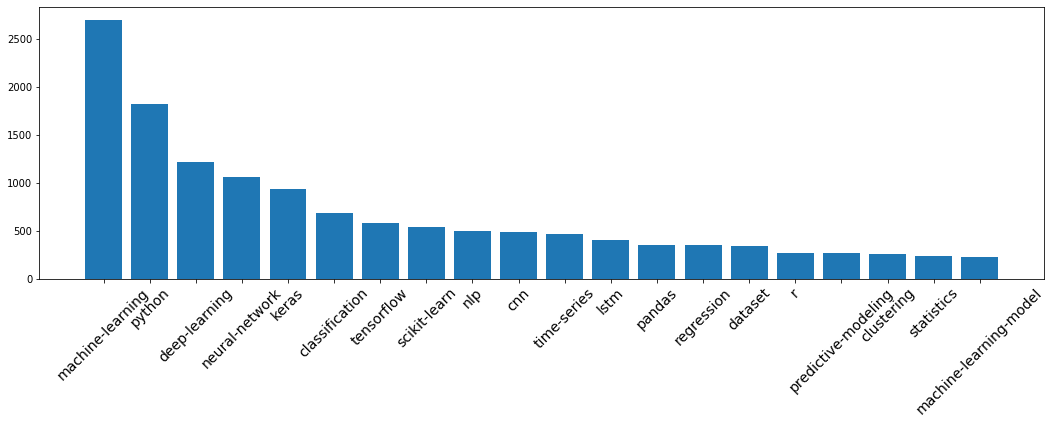

In [242]:
# let's check the used top 10 tags from the dictionary
top20_tags_counts = {k: v for k, v in sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:20]}

# visualize
plt.bar(range(len(top20_tags_counts)), list(top20_tags_counts.values()), align='center', figure=plt.figure(figsize=(18, 9)))
plt.xticks(range(len(top20_tags_counts)), list(top20_tags_counts.keys()), rotation=45, size=14)
plt.show()

Now that we have calculated tag usage, let's calculate how many times a tag was viewed.

In [243]:
# make a dictionary with all tags and 0 values
all_tag_views = {tag: 0 for tag in tag_counts.keys()}

# a function to count the tag view for each row
def count_tag_view(df_row):
    for tag in df_row["Tags"]:
        all_tag_views[tag] += df_row["ViewCount"]
        
# apply the function to the dataframe
none = df[["Tags", "ViewCount"]].apply(count_tag_view, axis=1)

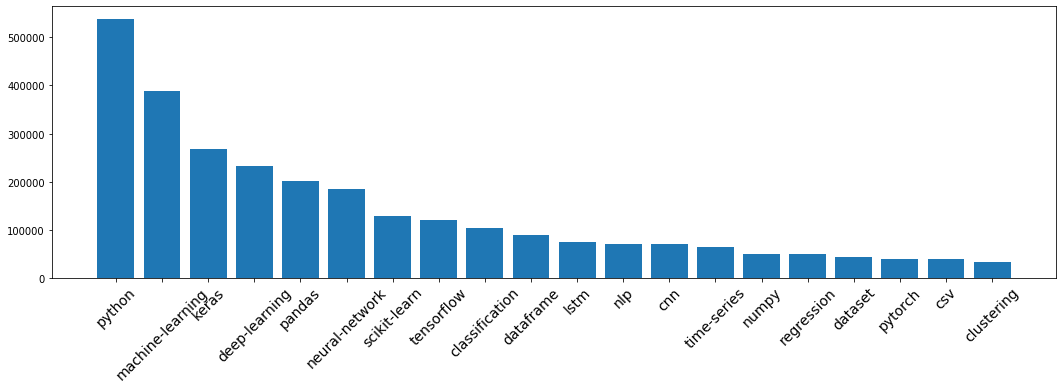

In [244]:
# sort the dicionary and also get top 20
top20_tag_views = {k: v for k, v in sorted(all_tag_views.items(), key=lambda x: x[1], reverse=True)[:20]}

# visualize
plt.bar(range(len(top20_tag_views)), list(top20_tag_views.values()), align='center', figure=plt.figure(figsize=(18, 9)))
plt.xticks(range(len(top20_tag_views)), list(top20_tag_views.keys()), rotation=45, size=14)
plt.show()

We can observe that the result is slight different but certain tags definitely come across in the top positions more than others.

Next, lets compare the top 20 used and top 20 viewed tags.

In [248]:
# generate dataframes from dictionaries using tag as index
most_used_df = pd.DataFrame.from_dict(top20_tags_counts, orient='index', columns=['most_used'])
most_viewed_df = pd.DataFrame.from_dict(top20_tag_views, orient='index', columns=['most_viewed'])

# merge two into one
most_df = pd.merge(most_used_df, most_viewed_df, how='outer', left_index=True, right_index=True)

# check the df
most_df

,most_used,most_viewed
classification,685.0,104457.0
clustering,257.0,33928.0
cnn,489.0,70349.0
csv,NaN,38654.0
dataframe,NaN,89352.0
dataset,340.0,43151.0
deep-learning,1220.0,233628.0
keras,935.0,268608.0
lstm,402.0,74458.0
machine-learning,2693.0,388499.0


We can ovbserve that some tags have been extensively used but not viewed (e.g. machine-learning-model) and some viewed a lot but not used (e.g. pytorch). From the list above we can say that some tags are related for example python and pandas, since pandas is built in python and questions about pandas would involve python code. Same could be said about scikit-learn and python.

To try to understand the relationship between tags we can have a look at top 20 used and viewed.

In [249]:
top20_tags_counts

{'machine-learning': 2693,
 'python': 1814,
 'deep-learning': 1220,
 'neural-network': 1055,
 'keras': 935,
 'classification': 685,
 'tensorflow': 584,
 'scikit-learn': 540,
 'nlp': 493,
 'cnn': 489,
 'time-series': 466,
 'lstm': 402,
 'pandas': 354,
 'regression': 347,
 'dataset': 340,
 'r': 268,
 'predictive-modeling': 265,
 'clustering': 257,
 'statistics': 234,
 'machine-learning-model': 224}

In [250]:
top20_tag_views

{'python': 537585,
 'machine-learning': 388499,
 'keras': 268608,
 'deep-learning': 233628,
 'pandas': 201787,
 'neural-network': 185367,
 'scikit-learn': 128110,
 'tensorflow': 121369,
 'classification': 104457,
 'dataframe': 89352,
 'lstm': 74458,
 'nlp': 71382,
 'cnn': 70349,
 'time-series': 64134,
 'numpy': 49767,
 'regression': 49451,
 'dataset': 43151,
 'pytorch': 40240,
 'csv': 38654,
 'clustering': 33928}

We can see that these tags are the same in both top 10 list, meaning they are top used and viewed:
* machine-learning
* deep-learning
* neural-network
* keras
* tensorflow
* scikit-learn
* classification
* python

In reality these tags are super related since they all discuss a similar technology but from different perspectives. For example tensorflow or keras are deep-learning libraries for building dee neural networks. Scikit-learn is a python library that provides possibility to build neural networks for classification or other machine-learning tasks. 

Overall, we can get an impression that deep-learning seems to be an overarching topic that is quite popular on the DSSE. We can try to check whether deep-learning is a fad by looking at the questions from a temporal perspective. We have a `all_questions.csv` file which contains all questions asked on DSSE.

We will try to track the interest in deep-learning across time. We plan to:
* Count how many deep learning questions are asked per time period.
* The total amount of questions per time period.
* How many deep learning questions there are relative to the total amount of questions per time period.

To perform the above operations we also need to define what question should be categorized as a deep-learning question. Based on our analysis of 2019, we can assume (using also our domain knowledge, and internet research) that deep-learning question would have at least one of these tags 
* deep-learning
* keras
* tensorflow
* neural-network

We also need to identify the adequate timeframe we want to track the interest for. It would be easier to read and understand if we do it a monthly basis across all the time.

In [345]:
# read dataset
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

# transform the tag column as we did before
all_questions["Tags"] = all_questions["Tags"].str.replace('<', '').str.replace('>', ' ').str.split()

# concept of deep-learning
dlp_tags = ["deep-learning", "keras", "tensorflow", "neural-network"]

# extract yearmonth
all_questions["yearmonth"] = all_questions["CreationDate"].dt.strftime("%Y%m")

# categorize the question as a deep-learning question
def categorize_dlp(row):
    for x in row:
        if str(x).strip() in dlp_tags:
            return 1
    return 0

# apply the function
all_questions["dlp_question"] = all_questions["Tags"].apply(categorize_dlp)

# groupby yearmonth and count dlp questions
dlp_overtime = all_questions[["yearmonth", "dlp_question"]].groupby("yearmonth").agg(["count", "sum"])

# get rid of multi level index columns and reset index
dlp_overtime.columns = dlp_overtime.columns.get_level_values(1)
dlp_overtime.columns = ["total_questions", "dlp_questions"]
dlp_overtime.reset_index(inplace=True)
dlp_overtime["yearmonth"] = dlp_overtime["yearmonth"].astype('str')

# calculate rate of dlp questions
dlp_overtime["dlp_rate"] = dlp_overtime["dlp_questions"] / dlp_overtime["total_questions"]

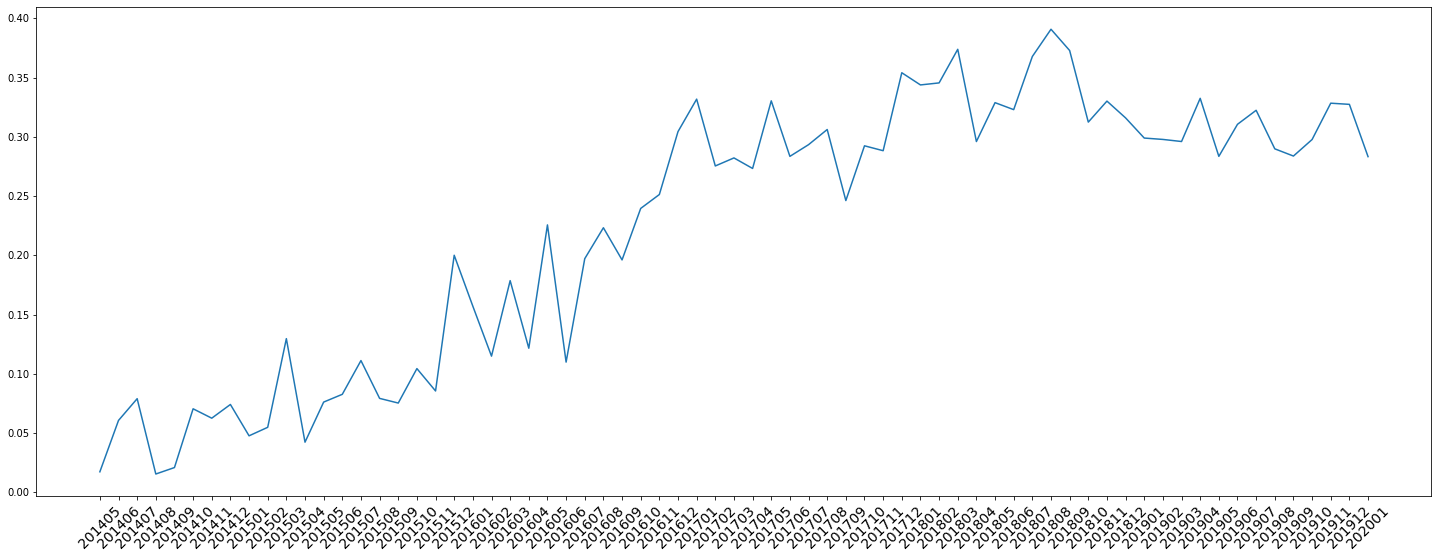

In [362]:
plt.plot(dlp_overtime["yearmonth"], dlp_overtime["dlp_rate"], figure=plt.figure(figsize=(25, 9)))
plt.xticks(dlp_overtime["yearmonth"], rotation=45, size=14)
plt.show()

# Conclusion & Summary

We can observe that deep-learning topic has been a more of a recent topic of interest and more questions about the topic have started coming up past 2017. Thus we can conclude that deep-learning is popular today.

We can further enhance our analysis by considering the following points
* What other content can we recommend that isn't as popular? You can try using association rules to find strong relations between tags.
* What other popularity features could we include in our analysis? Perhaps scores and favourite counts?
* We focused on other DSSE. How could we use other related sites to help us with our goal?
* How can we leverage other sites to determine what non-data-science content to write about? For example, is there some mathematical field that leads to more questions than others?

The above points is something to consider to perform more of a deep-dive.